In [1]:
"""
Data augmentation: 

Driving the model is too hard, also I'm really lazy, 
therefore I train the model using the example data

"""
import random
import cv2
import numpy as np
#Size of resized images
new_size_col,new_size_row = 64, 64

def bright_aug(img):
    # 1 Brightness augmentation
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    r_bright = .25+np.random.uniform()
    img[:,:,2] = img[:,:,2]*r_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img

def trans_image(image,steer,h_range, v_range):
    #.2 Horizontal and vertical shifts, each pixel shift to the left corresponds to 
    # an angle displacement of 0.002 degrees. This is subtracted to the left steering angle and 
    # added to the right steering angle
    
    #Make sure steering range is even number!
    #Horizontal shift
    rows,cols, _ = image.shape

    tr_x = random.randint(-h_range//2, h_range//2)
    steer_ang = steer+(tr_x*.2)
    
    #Vertical shift
    tr_y = random.randint(-v_range//2, v_range//2)
    
    #Affine transform matrix
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

def hor_flip(img, steer_ang):
    #.3 Flip images to simulate driving in opposite direction
    img=cv2.flip(img,1)
    return img, -steer_ang

#Preprocess data before training network
#Image preprocessing
#.1 Crop 1/5 of images: I.e. to remove horizon
#.2 Rescale image to 64 by 64: To speed up training
def prepImage(img):
    #Get rid of top 1/5 of image, and bottom 25 pixels
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    return img

In [2]:
import math

def data_aug_gen(d_frame):
    #Line data is extracted from pd data frame
    rand_p = np.random.randint(3)
    
    #Shift angles for non-centered camera angles
    if (rand_p == 0):
        column_name = 'left'
        path_file = d_frame['left'][0].strip()
        shift_ang = .25
    if (rand_p == 1):
        column_name = 'center'
        path_file = d_frame['center'][0].strip()
        shift_ang = 0.
    if (rand_p == 2):
        column_name = 'right'
        path_file = d_frame['right'][0].strip()
        shift_ang = -.25
    
    #get corresponding steering angle for center camera
    steer = d_frame['steering'][0] + shift_ang
    #read in image
    image = cv2.imread("data/"+path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #use left and right cameras for extra data, between random range
    image, steer= trans_image(image,steer,100, 20)
    #augment image brightness
    image =  bright_aug(image)
    #preprocess image data
    image = prepImage(image)
    image = np.array(image)
                  
    #flip image randomly
    ind_flip = np.random.randint(2)
    if ind_flip==1:
        image,steer = hor_flip(image, steer)
    
    return image,steer

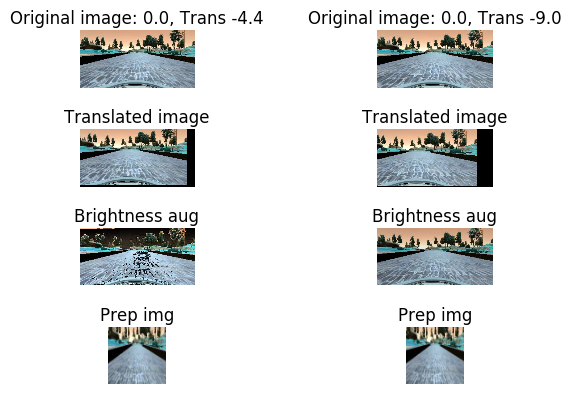

In [21]:
#Data exploration using augmented data set
import pandas as pd
import cv2
import matplotlib.pyplot as plt

d_f = pd.read_csv('data/driving_log.csv')
#read in 5 images from img folder
test_5 = d_f.head(5) 
t_images = []
for i in range(0, len(test_5)):
    t_images.append(cv2.imread(("data/"+test_5['center'][i])))

#Original angles:
aa1 = d_f['steering'][0]
aa2 = d_f['steering'][1]

#Test for brightness augmentation
after_0 = bright_aug(t_images[0])
after_1 = bright_aug(t_images[1])

tr1, a1 = trans_image(t_images[0],d_f['steering'][0],100,40)
tr2, a2 = trans_image(t_images[1],d_f['steering'][1],100,40)

im_flip1 = prepImage(t_images[0])
im_flip2 = prepImage(t_images[0])
 

# Visualizations will be shown in the notebook.
f, axarr = plt.subplots(4, 2)
axarr[0, 0].imshow(t_images[0]),axarr[0, 0].set_title("Original image: {}, Trans {}".format(aa1, a1)),axarr[0, 0].axis('off') 
axarr[0, 1].imshow(t_images[1]), axarr[0, 1].set_title("Original image: {}, Trans {}".format(aa2, a2)),axarr[0, 1].axis('off') 
axarr[1, 0].imshow(tr1), axarr[1, 0].set_title("Translated image"), axarr[1, 0].axis('off') 
axarr[1, 1].imshow(tr2), axarr[1, 1].set_title("Translated image"), axarr[1, 1].axis('off') 
axarr[2, 0].imshow(after_0), axarr[2, 0].set_title("Brightness aug"), axarr[2, 0].axis('off') 
axarr[2, 1].imshow(after_1), axarr[2, 1].set_title("Brightness aug"), axarr[2, 1].axis('off') 
axarr[3, 0].imshow(im_flip1), axarr[3, 0].set_title("Prep img"), axarr[3, 0].axis('off') 
axarr[3, 1].imshow(im_flip2), axarr[3, 1].set_title("Prep img"), axarr[3, 1].axis('off') 
plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)
plt.show()
%matplotlib inline   

In [22]:
#TO DO:
#1. Explore angle range throughout entire data set and plot
#2. Confirm that the augmented data set behaves and gives out correct angles
#3. Test trained model on simulation
#4. Split data into training, validation and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(d_f, test_size = 0.1)

![alt text](NVIDIA_end_to_end.png "Title")

In [25]:
#Final keras model based on NVDIA end to end soltn
#.3 Use Keras generator so not all data is kept in memory
#.4 Lambda layer in keras to normalize intensities between -.5 and .5.
#.5 We will utilize kera’s generator function to sample images such 
#that images with lower angles have lower probability of getting represented in the data set

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))

model.add(Convolution2D(3,1,1,
                        border_mode='valid',
                        name='conv0', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv1', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv6', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512,name='hidden1', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', init='he_normal'))

In [8]:
#Generator for training 
def generate_train_from_PD(data):
    while 1:
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        x,y = data_aug_gen(line_data)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        y = np.array([[y]])
        yield x, y

def generate_valid_from_PD(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x,y = data_aug_gen(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = np.array([[y]])
            yield x, y


In [ ]:
#Conv RNN implementation

In [26]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,
          loss='mse')

In [29]:
#Training loop
batch_size = 10

val_size = len(d_f)

batch_size = 256

train_gen =generate_train_from_PD(train)
valid_s_generator = generate_valid_from_PD(train)
history = model.fit_generator(train_gen,
            samples_per_epoch=2000, nb_epoch=10,validation_data=valid_s_generator,
                        nb_val_samples=val_size)

Epoch 1/10
2000/2000 [==============================] - 287s - loss: 30.5469 - val_loss: 26.4408
Epoch 2/10
2000/2000 [==============================] - 278s - loss: 20.4716 - val_loss: 14.5378
Epoch 3/10
2000/2000 [==============================] - 290s - loss: 16.2632 - val_loss: 12.1225
Epoch 4/10
2000/2000 [==============================] - 299s - loss: 13.0769 - val_loss: 6.8600
Epoch 5/10
2000/2000 [==============================] - 323s - loss: 11.5226 - val_loss: 4.6549
Epoch 6/10
2000/2000 [==============================] - 306s - loss: 10.4038 - val_loss: 4.6683
Epoch 7/10
2000/2000 [==============================] - 269s - loss: 10.0079 - val_loss: 8.0227
Epoch 8/10
2000/2000 [==============================] - 302s - loss: 8.9756 - val_loss: 3.6844
Epoch 9/10
2000/2000 [==============================] - 375s - loss: 8.7671 - val_loss: 3.4732
Epoch 10/10
2000/2000 [==============================] - 372s - loss: 8.1939 - val_loss: 4.3025


In [31]:
#Save final model as specified in Udacity ruberic
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save('model.h5') 
print("Saved model to disk")
'''
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)'''

Saved model to disk


'\n# load json and create model\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n \n# evaluate loaded model on test data\nloaded_model.compile(loss=\'binary_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)'